In [7]:
import numpy as np, basic, analysis as ana
from matplotlib.pyplot import *
from scipy.optimize import curve_fit
import prjlib

In [8]:
def likefunc(A,c0,c1,mscb,icov,bi=0):
    bn = np.shape(mscb)
    return np.exp(prjlib.lnLLH(A/c0*np.ones(bn),c1*mscb,icov,bi))

def fitlikefunc(xdat,ydat,yerr,mscb,icov,c1=None,bi=0):
    bn = np.shape(mscb)
    index = np.where(yerr==0.)
    x = np.delete(xdat,index)
    y = np.delete(ydat,index)
    s = np.delete(yerr,index)
    if c1 is None:
        like = lambda x, c0, c1: np.exp(prjlib.lnLLHs(x/c0,c1*mscb,icov,bi))
        p, __ = curve_fit(like,x,y,sigma=s,p0=[1.,1.])
        return p[0], p[1]
    else:
        like = lambda x, c0: np.exp(prjlib.lnLLHs(x/c0,mscb,icov,bi))
        p, __ = curve_fit(like,x,y,sigma=s,p0=[1.])
        return p[0]

In [9]:
def binning(ocl,scl,acl,n0,N0,bn,bn1=9,lmin=10,Lsp=2048):
    mb, mb0, mb1 = prjlib.binning_all(bn,bn1,lmin,Lsp)
    acb = prjlib.binning(acl+N0[None,:],mb0,mb1)
    macb = np.mean(acb,axis=0)
    scb = prjlib.binning(scl+n0[None,:],mb0,mb1)
    ocb = prjlib.binning(ocl+n0,mb0,mb1)
    mscb = np.mean(scb,axis=0)
    icov = ana.get_cov(scb,cinv=True)
    return mb, ocb, scb, mscb, acb, macb, icov

In [10]:
def loaddata(patch,bn,lmin): #output binned spectra
    if patch == 'boss':
        rlmin = '300'
        snmax = 100
    if patch == 'deep56':
        rlmin = '200'
        snmax = 200
    ps, __ = prjlib.filename_init(rlmin=rlmin,stype='lcmb',PSA='s14&15_'+patch,doreal='True',dearot='True')
    pa, __ = prjlib.filename_init(rlmin=rlmin,stype='a0p1',PSA='s14&15_'+patch)
    n0 = np.loadtxt(ps.quad.f['EB'].n0bl,unpack=True)[1]
    N0 = np.loadtxt(pa.quad.f['EB'].n0bl,unpack=True)[1]
    scl = np.array([np.loadtxt(ps.quad.f['EB'].cl[i],unpack=True)[1] for i in range(1,snmax+1)])
    acl = np.array([np.loadtxt(pa.quad.f['EB'].cl[i],unpack=True)[1] for i in range(1,101)])
    ocl = np.loadtxt(ps.quad.f['EB'].ocls,unpack=True)[1]
    mb, ocb, scb, mscb, acb, macb, icov = binning(ocl,scl,acl,n0,N0,bn,lmin=lmin)
    return mb, ocb, scb, mscb, acb, macb, icov

In [28]:
def fit_c0c1(patch,bn=10,histbn=15,lmin=10,do_plot=False):
    # output fit c0 and c1
    mb, ocb, scb, mscb, acb, macb, icov =loaddata(patch,bn,lmin)
    c0 = np.zeros(mb.n)
    c1 = np.zeros(mb.n)
    for bi in range(mb.n):
        # fit likelihood
        Ab = acb[:,bi]/macb[bi]
        #Ab = scb[:,bi]/mscb[bi]
        N, be = np.histogram(Ab,bins=histbn)
        An = (be[1:]+be[:-1])*.5
        yerr = np.sqrt(N)/np.max(N)
        c0[bi], c1[bi] = fitlikefunc(An,N/np.max(N),yerr,mscb,icov,bi=bi)
        #c0[bi] = fitlikefunc(An,N/np.max(N),yerr,mscb,icov,c1=1.,bi=bi)
        #c1[bi] = 1.
        if do_plot:
            print(c0[bi],c1[bi])
            # plot
            rcParams["figure.figsize"] = (6,4)
            A = np.arange(np.min(Ab),np.max(Ab),(np.max(Ab)-np.min(Ab))/50.)
            Lh = np.array([likefunc(a,c0[bi],c1[bi],mscb,icov,bi) for a in A])
            ylim(0,1)
            plot(A,Lh/np.max(Lh),'r-',label='HL')
            ana.hist_errorbars(Ab,bins=histbn)
            legend(loc=0,frameon=False)
            show()
            clf()

    return ocb,scb,mscb,macb,icov,c0,c1

In [49]:
# fit direct distribution with HL likelihood
c0, c1, ocb, scb, mscb, macb, icov = {}, {}, {}, {}, {}, {}, {}
#for p in ['boss','deep56']:
for p in ['deep56']:
    ocb[p], scb[p], mscb[p], macb[p], icov[p], c0[p], c1[p] = fit_c0c1(p,bn=10,lmin=20)
    print(c0[p],c1[p])

[0.95661063 0.99142854 0.99125946 0.99650254 1.00241604 0.99318065
 0.99964806 0.99636021 0.99701351 0.99824935] [1.43094182 1.06247216 1.1565134  0.84018656 1.31685366 0.97130594
 0.89918059 0.68211868 0.70749562 0.74238279]


0.10300000000000001 0.1075 0.11812000000000002
0.04033002362136088


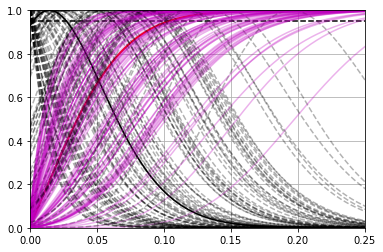

<Figure size 432x288 with 0 Axes>

In [52]:
# likelihood
#for p in ['deep56','boss','cross']:
for p in ['deep56']:
    A = np.arange(0.,0.3,0.001) 
    Ai = np.zeros(100)
    CL = np.zeros(100)
    ylim(0,1)
    xlim(0,0.25)
    grid(True)
    axhline(0.95,color='k',ls='--')
    for i in range(100):
        if p=='cross':
            Lh0 = prjlib.posterior(A,scb['deep56'][i,:],mscb['deep56'],macb['deep56'],icov['deep56'],c0['deep56'],c1['deep56'])
            Lh1 = prjlib.posterior(A,scb['boss'][i,:],mscb['boss'],macb['boss'],icov['boss'],c0['boss'],c1['boss'])
            Lh = Lh0*Lh1
        else:
            Lh = prjlib.posterior(A,scb[p][i,:],mscb[p],macb[p],icov[p],c0[p],c1[p])
            if i==0: Lh = prjlib.posterior(A,ocb[p],mscb[p],macb[p],icov[p],c0[p],c1[p])
        plot(A,Lh/np.max(Lh),'k--',alpha=.3)
        if i==0: plot(A,Lh/np.max(Lh),'k-')
        CDF = np.cumsum(Lh)/np.sum(Lh)
        plot(A,CDF,'m-',alpha=.3)
        if i==0: plot(A,CDF,'r-',lw=2)
        Ai[i] = A[np.argmax(Lh)]
        CL[i] = A[np.abs(CDF-0.95).argmin()]

    print(CL[0],np.median(CL),np.mean(CL))
    print(np.sqrt(CL[0]*1e-4)*4*np.pi)
    #ana.hist_errorbars(CL[0],bins=30)
    #ana.hist_errorbars(CL,bins=30)
    show()
    clf()